<a href="https://colab.research.google.com/github/inf104776/sarcasmDetection/blob/master/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sarkasmuserkennung

Im Bereich des Natural Language Processing (NLP) gibt es verschiedene Anwendungsziele. Viele beschäftigen sich mit dem Inhalt des Gesprochenen oder des Textes. Ein Fall, der nicht nur für den Computer eine Herausforderung bietet, sondern auch häufiger für den Menschen selbst, ist das Erkennen von Sarkasmus. 
Der [Duden](https://www.duden.de/rechtschreibung/Sarkasmus) beschreibt Sarkasmus als: "beißender, verletzender Spott, Hohn, der jemanden, etwas lächerlich machen will". Die Schwierigkeit ist meist, heruaszufinden, ob etwas ernst oder sarkastisch gemeint ist. Es benötigt eine genaue Analyse des Kontextes. Oftmals sind es auch nur Betonungn, die verraten, dass es sich um Sarkasmus handelte.
In direkter Verbindung dazu steht die Ironie, die immer das Gegenteil der getätigten Aussage bezeichent. Ironie ist nicht immer auch sarkastisch, kann aber im Zuge dessen verwendet werden.  

Um textuellen Sarkasmus zu erkennen, muss der Text vor allem inhaltlich klassifiziert werden. 
Dies wird mit gängigen Methoden des Natural Language Processings und Text Mining realisiert. 

Ziel des Projektes ist es, ein Model zu entwickeln, welches anhand eines Textes zurückliefert, ob es sich um Sarkasmus handelt oder nicht.

## Projektbeschreibung

In diesem Projekt soll versucht werden mittels künstlicher Intelligenz und Methoden des Text-Mining Sarkasmus zu erkennen. Dafür wurde ein Datansatz ausgesucht, der aus Überschriften von Onlineartikeln besteht, welche aus zwei unterschiedlichen Quellen stammt. Die eine ist eine Satire-Seite ("The Onion"), die andere ist eine seriöse Pressestelle ("The Huffington Post").  

# Datenbeschaffung


Die Daten kommen aus [Kaggle](https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection?select=Sarcasm_Headlines_Dataset.json) und werden im Folgenden eingelesen. Ein Datensatz besteht aus drei Komponenten: die zu klassifizierende Überschrift, einem Label und einem Link zu dem entsprechenden Artikel. Das Label gibt an, ob ein Artikel sarkastisch ist (1) oder nicht (0).

## Web-Crawler

Um genauere Klassifizierungen zu gewährleisten, wird zu jedem Datensatz der Inhalt des Artikels benötigt, so dass in der Klassifizierung ein Kontext zu der Überschrift existiert. Der Inhalt des Artikels wird aus dem Link im Datensatz ausgelesen. Existiert kein Artikel mehr oder gibt es zu einer Überschrift keinen Text, sondern nur ein Bild, wird dieser Datensatz aus dem Gesamtsatz gestrichen.

In [ ]:
#@title
import bs4 as bs
import urllib.request

### Crawler Huffpost

```
<body>
  <div class="body-wrap">
    <div class="main">
      <div id="main">
        <div class="entry__body js-entry-content">
          <div class="entry__body js-entry-body">
            <div class="entry__text js-entry-text yr-entry-text">
              <div class="content-list-component yr-content-list-text text">
                <a></a>
              </div>
            </div>
          </div>
        </div>
      </div>
    </div>
  </div>
</body>
```



In [ ]:
#@title
def crawlHuffPost(url):
  text = ""
  try:
    user_agent = 'Mozilla/5.0 (Windows NT 6.1; Win64; x64)'
    headers = { 'User-Agent' : user_agent }

    req = urllib.request.Request(url, None, headers)
    soup = bs.BeautifulSoup(urllib.request.urlopen(req).read(),'lxml')
    
    for div in soup.find_all("div", class_="content-list-component yr-content-list-text text"):
      for paragraph in soup.find_all("p"):
        for content in paragraph.contents:
          if isinstance(content, str):
            if text != "":
              text += " "
            text += content
          else: 
            for linkcontent in content:
              if isinstance(linkcontent, str):
                text += linkcontent
  except:
    print ("Error in HuffPost!")
  return text

### Crawler Onion

```
<body>
  <div>
    <div> 
      <main>
        <div>
          <div class="js_starterpost">
            <div class="r[...]lxo-0 hEDDLA js_post-content">
              <p></p>
            </div>
          </div>
        </div>
      </main>
    </div>
  </div>
</body>
```



In [ ]:
#@title
def crawlOnion(url):
  text = ""
  try:
    soup = bs.BeautifulSoup(urllib.request.urlopen(url).read(),'lxml')

    def is_post_content(css_class):
        return css_class is not None and "hEDDLA js_post-content" in css_class

    for div in soup.find_all("div", class_=is_post_content):
      paragraph = div.find("p")
      if paragraph == None:
        break
      for content in paragraph.contents:
        if isinstance(content, str):
          text += content
  except:
    print ("Error in Onion!")  
  return text

## Daten einlesen

In [ ]:
#@title
import numpy
import scipy
import matplotlib
import sklearn
import pandas
import urllib
import requests
import json
import re
import csv

In [ ]:
#@title
f_csv = open('/content/data/test_data.csv', 'w')
f_json = open('/content/data/test_data.json', 'w')

with f_csv and f_json:

    fnames = ['is_sarcastic', 'headline', 'article_link', 'context']
    csv_writer = csv.DictWriter(f_csv, fieldnames=fnames)    
    csv_writer.writeheader()

    json_data = {}
    json_data['entries'] = []

    link = "https://raw.githubusercontent.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection/master/Sarcasm_Headlines_Dataset.json"
    resp = requests.get(url=link)
    if resp.status_code == 200:

      counter = 0

      for line in resp.iter_lines():
    
        #todo nur mit , splitten nicht gut -> regex
        enrty_elements = str(line, 'utf-8').split(', "')
        entry = {}
        #
        for i in range(len(enrty_elements)):
          #key:content
          matches = enrty_elements[i].split(': ')
          if len(matches) >= 2: 
            #key
            matches[0] = matches[0].replace('\"', '').replace('{', '').strip()
            content = ''
            for i in range (1, len(matches)):
              content += (matches[i].replace('"', '').replace('}', '').strip())

            entry[matches[0]] = content
        try:
          url = entry["article_link"]
          content = ""
          if "theonion.com" in url:
            content = crawlOnion(url)
          elif "huffingtonpost.com" in url:
            content = crawlHuffPost(url)
          else:
            print(url)
          
          if content != "":
            entry["context"] = content
            # Write entry to file
            json_data['entries'].append(entry)
            csv_writer.writerow(entry)

            counter +=1

        except KeyError:
          print (entry)

    json.dump(json_data, f_json)
    print ("Number of entries: ", counter)


### Daten bereiningen

Um mit den beschafften Daten arbeiten zu können, müssen diese zuvor bereinigt werden. Das bedeutet, dass mit Daten umgegangen werden muss, die unvollständig oder falsch sind. Im Falle dieses Projektes werden die Daten gelöscht.


In [ ]:
#@title
import json
import csv
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/full_data.csv', sep=",")
# remove missing values 
df['headline'].dropna(inplace=True)

Außerdem können Werte, die nicht gebraucht werden, gelöscht werden. In diesem Fall handelt es sich um die Spalte "article_link". Sie ist nach dem Auslesen des Kontextes nicht mehr von Nutzen.

In [ ]:
#@title
df.drop('article_link', axis='columns', inplace=True)

In [ ]:
#@title
#save dataframe
f_csv = open('/content/data_cleaned.csv', 'w')
f_json = open('/content/data_cleaned.json', 'w')
with f_csv and f_json:
    df.to_csv(f_csv, index=False)
    json_data = df.to_json(orient="index")
    json.dump(json_data, f_json)

#EDA und Feature-Extraktion

Um Sarkasmus in Texten zu erkennen, muss der Text analysiert werden und die Features zur Klassifizierung extrahiert werden.

*Komponente*  | *Features*
------     | ------
**Headline**   | <ul><li>Sentiment</li><li>Emotionen</li><li>Slang</li></ul>  
**Context**    | <ul><li>Sentiment</li><li>Emotionen</li><li>Slang</li></ul>

### Verteilung der Daten

Ein Blick auf die Verteilung der Daten gibt einen Überblick darüber, ob die Balance stimmt. Gibt es viel mehr sarkastisch gelabelte Daten als nicht sarkastische, könnte das das Training des Neuronalen Netzes negativ beeinflussen, da ein Ungleichgewicht an Informationen herrscht.
Um sicherzustellen, dass das Training für sarkastisch und nicht sarkastisch gleichermaßen gut funktioniert, muss dafür gesorgt werden, dass im Datensatz ungefähr gleich viele gelabelte Daten von beiden Kategorien vorhanden sind.
Insgesamt besteht der Datensatz aus 21799 gelabelten Artikeln.

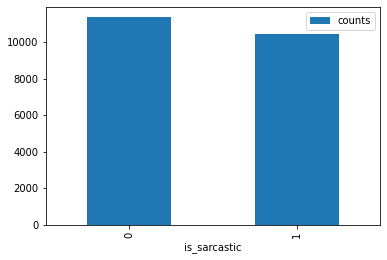

In [ ]:
#@title
import matplotlib.pyplot as plt
import pandas as pd
#Seperate labels and display balance
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test_data.csv', sep=",")
counts_df = pd.DataFrame(df.groupby('is_sarcastic').size().reset_index(name='counts'))
plot = counts_df.plot.bar(x='is_sarcastic', y='counts')

Die Zählung der Elemente aus dem Datensatz ergab einen geringen Überschuss an nicht sarkastischen Daten. Es ist aber auch eine Balance zu sehen, daher können die Daten ohne weitere Maßnahmen zum Trainieren verwendet werden.

### Wordcloud

Für einen Überblick über die Daten und ihren Inhalt lässt sich eine Wordcloud verwenden. Sie beschreibt die am häufigsten vorkommenden Worte in den gegebenen Texten. Im Folgenden wird unterschieden zwischen sarkastischen Texten und nicht sarkastischen Texten. 

In [ ]:
#@title
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

Wordcloud für die sarkastischen Headlines:


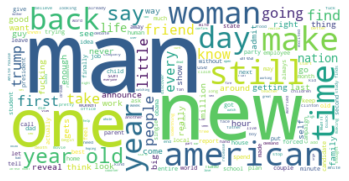

Wordcloud für die nicht sarkastischen Headlines:


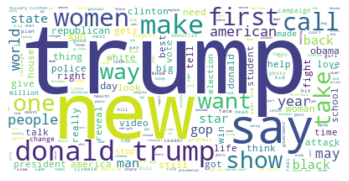

In [ ]:
#@title
# Einlesen der Daten und Zusammenführung von Headlines unterschieden in sarkasitischen und nicht sarkasitischen 
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test_data.csv', sep=",")
df_is_sarcastic = df['is_sarcastic'] == 1
df_is_not_sarcastic = df['is_sarcastic'] == 0
df_sarcastic = df[df_is_sarcastic]
df_not_sarcastic = df[df_is_not_sarcastic]
headlines_sarcastic = df_sarcastic['headline'].values
headlines_not_sarcastic = df_not_sarcastic['headline'].values
text_not_sarcastic = "".join(headlines_not_sarcastic)
text_sarcastic = "".join(headlines_sarcastic)
# Initialisierung von Stopwords
stopwords_list = stopwords.words('english')
STOPWORDS.update(stopwords_list)
# Wordclouds erstellen
wordcloud_not_sarcastic = WordCloud(background_color="white").generate(text_not_sarcastic)
wordcloud_sarcastic = WordCloud(background_color="white").generate(text_sarcastic)
#Ausgabe
print("Wordcloud für die sarkastischen Headlines:")
plt.imshow(wordcloud_sarcastic, interpolation="bilinear")
plt.axis("off")
plt.show()
print("Wordcloud für die nicht sarkastischen Headlines:")
plt.imshow(wordcloud_not_sarcastic, interpolation="bilinear")
plt.axis("off")
plt.show()

### Wort- und Textlänge

Ein weiteres Feature im NLP, das zur Analyse eines Textes verwendet werden kann, ist die Anzahl der Worte, also die Länge des Textes. 

In seriösen Artikeln soll der Leser sachlich informiert werden. Wir vermuten, dass sich dieses in der Textlänge wiederspiegeln könnte, da in einem objektiven Artikel der Sachverhalt aus mehreren Perspektiven betrachtet wird, während das bei sarkastischen Texten nicht der Fall sein muss, da dieser durchaus polarisierend geschrieben sein kann.

Zudem ist ein objektiver, sachlicher Artikel eines serösen Nachrichtenportals nicht zwangsläufig in einfacher Sprache geschrieben, was sich in der durchschnittlichen Wortlänge wiederspiegeln könnte und gleichzeitig auch in einem längeren Text.

In [ ]:
#@title
# Clean texts to lowercase without punctuation
def clean_and_split(text):
    #convert to lowercase
    text = text.lower()
    #delete punctuation
    cleaned = text.translate(str.maketrans("", "", string.punctuation))
    return cleaned.split()

In [ ]:
#@title
def count_word_length(words):
    word_length_occ = [0] * 25
    for word in words:
        if len(word_length_occ) > len(word):
          word_length_occ[len(word)] += 1
        else:
          word_length_occ[len(word_length_occ) - 1] += 1
    return word_length_occ

In [ ]:
#@title
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test_data.csv', sep=",")
count_1_headline = []
count_0_headline = []
count_0_context = []
count_1_context = []
wl_occ_0_headline = [0] * 25
wl_occ_1_headline = [0] * 25
mean_0 = 0.0
mean_1 = 0.0
for index, row in df.iterrows():
  headline_tokens = clean_and_split(row['headline'])
  context_tokens = clean_and_split(row['context'])
  word_length_occ_headline = count_word_length(headline_tokens)
  word_length_occ_context = count_word_length(context_tokens)
  mean = 0.0
  if row['is_sarcastic'] == 1:
    count_1_headline.append(len(headline_tokens))
    count_1_context.append(len(context_tokens))
    for i in range(len(word_length_occ_headline)):
      wl_occ_1_headline[i] += word_length_occ_headline[i]
      mean += word_length_occ_headline[i] * i
    mean = round(mean / len(headline_tokens), 2)
    mean_1 += mean
  else:
    count_0_headline.append(len(headline_tokens))
    count_0_context.append(len(context_tokens))
    for i in range(len(word_length_occ_headline)):
      wl_occ_0_headline[i] += word_length_occ_headline[i]
      mean += word_length_occ_headline[i] * i
    mean = round(mean / len(headline_tokens), 2)
    mean_0 += mean
mean_0 = round(mean_0 / len(count_0_headline), 2)
mean_1 = round(mean_1 / len(count_1_headline), 2)

**Textlänge anhand von Anzahl an Worten:**

In [ ]:
#@title
print("Durchnittliche Anzahl an Worten in nicht sarkastischen Überschriften: ", round(sum(count_0_headline) / len(count_0_headline), 2))
print("Durchnittliche Anzahl an Worten in sarkastischen Überschriften: ", round(sum(count_1_headline) / len(count_1_headline), 2))
print("Durchnittliche Anzahl an Worten in nicht sarkastischen Artikeln: ", round(sum(count_0_context) / len(count_0_context), 2))
print("Durchnittliche Anzahl an Worten in sarkastischen Artikeln: ", round(sum(count_1_context) / len(count_1_context), 2))

Durchnittliche Anzahl an Worten in nicht sarkastischen Überschriften:  9.85
Durchnittliche Anzahl an Worten in sarkastischen Überschriften:  10.62
Durchnittliche Anzahl an Worten in nicht sarkastischen Artikeln:  13252.12
Durchnittliche Anzahl an Worten in sarkastischen Artikeln:  151.22


**Beispiel anhand zufällig ausgewählte Artikel:**

In [ ]:
#@title
print("Sarkastischer Artikel: " ,df['is_sarcastic'][5])
print(df['headline'][5])
print(df['context'][5])

Sarkastischer Artikel:  1
shadow government getting too large to meet in marriott conference room b
COLUMBUS, OH—With its membership swelling in recent months, the mysterious organization that secretly pulls the levers of American power was forced to suspend its weekly meeting Monday, having grown too big to fit inside Marriott Conference Room B. "To successfully carry out our clandestine operations and continue maintaining the ignorance of the masses, we will now require the full amenities of Conference Room A," said an unidentified man, who is believed to have covertly orchestrated the economic collapse of Iceland last year. "We must postpone the Cataclysmic Event until such time as a more comfortable meeting space is available." According to confidential records, the hidden regime's enrollment has more than doubled since it gained free access to the Marriott's swimming pool and gym facilities.


In [ ]:
#@title
print("Nicht sarkastischer Artikel: " ,df['is_sarcastic'][201])
print(df['headline'][201])
print(df['context'][201])

Nicht sarkastischer Artikel:  0
senate panel unanimously approves chris wray's nomination as fbi director
WASHINGTON, July 20 (Reuters) - The U.S. Senate  Judiciary Committee on Thursday unanimously approved the nomination of Christopher Wray to be FBI  director following the dismissal of the agency’s former chief, James Comey, by President Donald Trump . All 20 members of the committee voted to approve Wray, a white-collar crime lawyer and former assistant attorney general under President George W. Bush, sending his nomination to the full Senate for a vote. Trump nominated Wray last month after firing Comey during an FBI investigation into whether Trump campaign associates colluded with the Russians to help him with the 2016 presidential election. (Reporting by Washington Newsroom; Editing by Chizu Nomiyama)Do you have information you want to share with HuffPost?  WASHINGTON, July 20 (Reuters) - The U.S. Senate  Judiciary Committee on Thursday unanimously approved the nomination of Ch

Ein Blick in die Daten zeigt, dass in den meisten Fällen die sarkastischen Artikel viel kürzer als die nicht sarkastischen sind (siehe auch Beispiel). Das hängt bei den gegebenen Daten mit der Datenquelle zusammen, d.h. das Portal *theOnion.com* schreibt generell kürzere Artikel, die sarkastisch sind, während auf anderen Seiten sarkastische Texte auch länger sein können. Das Portal *huffingtonpost.com* schreibt hingegen längere Artikel, während andere seriöse Nachrichtenseiten kürzere Artikel schreiben könnten. Das führt dazu, dass dieses Feature nicht genutzt werden kann, da es unbemerkt zu einem Overfitting kommen würde, wenn sich der Klassifikator auf dieses Feature bezieht.

Die Überschriften, sowohl zu sarkastischen als auch nicht sarkastischen Texten, in diesem Datensatz sind etwa gleich lang. Da dieses Projekt darauf abzielt, anhand von Überschriften Sarkasmus zu erkennen und der Artikelinhalt nur als Einordnung und Kontext analysiert wird, wird die Textlänge als Feature nicht weiter berücksichtigt, da eine Korrelation zwischen Sarkasmus und der Anzahl der Worte in einer Überschrift als unwahrscheinlich eingestuft wird.

**Wortlänge**

In [ ]:
#@title
print("Durchschnittliche Wortlänge bei nicht sarkastischen Überschriften: ", mean_0)
print("Durchschnittliche Wortlänge bei sarkastischen Überschriften: ", mean_1)

Durchschnittliche Wortlänge bei nicht sarkastischen Überschriften:  5.27
Durchschnittliche Wortlänge bei sarkastischen Überschriften:  5.5


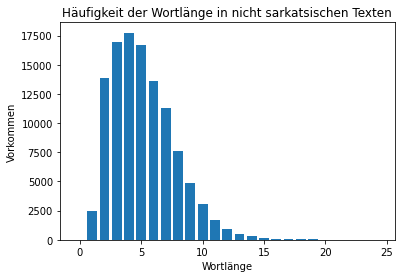

In [ ]:
#@title
plt.bar([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24], wl_occ_0_headline)
plt.xlabel("Wortlänge")
plt.ylabel("Vorkommen")
plt.title("Häufigkeit der Wortlänge in nicht sarkatsischen Texten")
plt.show()

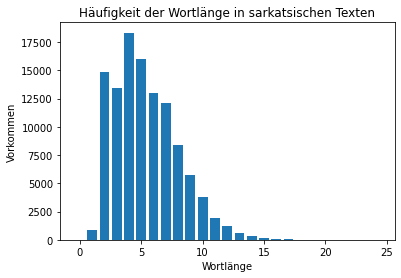

In [ ]:
#@title
plt.bar([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24], wl_occ_1_headline)
plt.xlabel("Wortlänge")
plt.ylabel("Vorkommen")
plt.title("Häufigkeit der Wortlänge in sarkatsischen Texten")
plt.show()

Die Analyse der Wortlänge führte ebenfalls dazu, dass dieses Feature verworfen werden musste, da kein signifikanter Unterschied festgestellt werden konnte. 

##Sentimentanalyse

In der Sentimentanalyse werden die Texte auf Polarität (polarity) geprüft, wobei diese einem Wert zwischen -1.0 und +1.0 zugeordnet wird. -1.0 steht dabei für ein sehr negatives Statement und +1.0 für ein sehr positives. Außerdem wird die Subjektivität (subjectivity) auf einer Skala von 0.0 bis 1.0 bestimmt. 1.0 ist dabei sehr subjektiv und 0.0 sehr objektiv.
Die Bestimmung des Sentiments könnte bei der Erkennung von Sarkasmus helfen. Dies wäre z.B. dann der Fall, wenn sarkastische Texte häufiger subjektiv und/oder polarisiert geschrieben wurden oder wenn die Subjektivität oder Polarität dort stärker ausgeprägt ist.

In [ ]:
#@title
# Import for sentiment analysis
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')
from textblob import TextBlob
import pandas as pd
import csv
import json

###Sentimentanalyse von Überschrift und Inhalt

Hier wird das Sentiment der Überschrift und des Inhaltes der Artikel bestimmt und als Feature gespeichert. Zusätzlich wird der Zusammenhang mit dem Sarkasmus-Label analysiert.
Überschrift und Inhalt werden zusammen betrachtet, da eine erste Untersuchung gezeigt hat, dass die Überschrift alleine oft als neutral aus der Analyse hervor geht und mit dem Inhalt zusammen einen möglicherweise aussagekräftigeren Wert produziert.

In [ ]:
#@title
f_csv = open('/content/drive/My Drive/Colab Notebooks/sentiments.csv', 'w')
with f_csv:
    #prepare csv summary analysis
    fnames = ['is_sarcastic', 'polarity', 'subjectivity']
    csv_writer = csv.DictWriter(f_csv, fieldnames=fnames)    
    csv_writer.writeheader()
    #read dataframe
    df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data_1.csv', sep=",")
    #insert new column for polarity
    df.insert( len(df.columns), "polarity", 0.0, True) 
    #insert new column for subjectivity
    df.insert( len(df.columns), "subjectivity", 0.0, True) 
    #process each row
    for index, row in df.iterrows():
        entry = {}
        #concat headline and context for analysis
        text = row['headline'] + "\n" + row['context']
        #get sentiment blob
        blob = TextBlob(text)
        #write entry for summary
        entry['is_sarcastic'] = row['is_sarcastic']
        entry['polarity'] = blob.sentiment[0]
        entry['subjectivity'] = blob.sentiment[1]
        csv_writer.writerow(entry)
        #write features to dataframe
        df.at[index,'polarity'] = blob.sentiment[0]
        df.at[index,'subjectivity'] = blob.sentiment[1]
    #save dataframe
    f_csv = open('/content/test_data_1.csv', 'w')
    f_json = open('/content/test_data_1.json', 'w')
    with f_csv and f_json:
        df.to_csv(f_csv, index=False)
        json_data = df.to_json(orient="index")
        json.dump(json_data, f_json)

Im Folgendem werden die Ergebnisse als Box-Plot-Diagramme dargestellt, um mögliche Zusammenhänge zu verdeutlichen. Es werden Artikelinhalt und -überschrift zusammen verwendet, da die Wortlänge im Artikel selbst hier nicht als Teil des Kontextes betrachtet wird, der aus dem Artikelinhalt extrahiert werden soll. 

Der Boxplot zeigt den Median in der Mitte der *Box*, das 25er- und das 75er-Perzentil als untere und obere Seite der *Box* sowieo das Minimum und Maximum. Die schwarzen Kreise sind Ausreißer. Da der Datensatz relativ viele Daten beinhaltet, gibt es auch entsprechend viele Ausreißer.

In [ ]:
#@title
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sentiments.csv', sep=",")

**Boxplot für die Polarität abhängig vom Sarkasmus:**

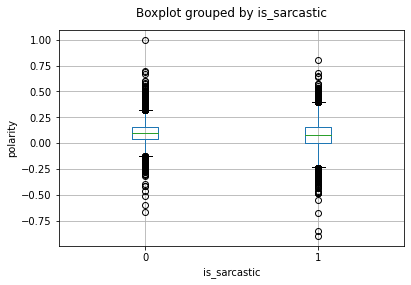

In [ ]:
#@title
boxplot = df.boxplot('polarity', 'is_sarcastic')
boxplot.set_ylabel("polarity")
titel = boxplot.set_title("")

Beim Boxplot der Polarität sieht man zwar, dass das 25er- und 75er-Perzentil sowie die beiden Maxima bei sarkastischen Texten weiter auseinanderliegen, jedoch ist der Unterschied eher marginal. Beim Wert des Medians gibt es noch weniger Abweichung. Das bedeutet, dass die Texte im Durchschnitt wenig polarisierend sind, bei den nicht sarkastischen ist die Polarisierung jedoch noch etwas weniger ausgeprägt.  Das zeigt sich auch an der Ausprägung der Ausreißer.
Im Bezug auf die vielen Ausreißer stufen wir die Signifikanz der Maxima als eher gering ein, da der größte Teil der Ausreißer und Maxima relativ nahe beieinander liegen. 

Aus diesem Boxplot ziehen wir den Schluss, dass die Polarität sich im Allgemeinen zwischen sarkastischen und nicht sarkastischen wenig unterscheidet.

**Boxplot für die Subjektivität abhängig vom Sarkasmus:**

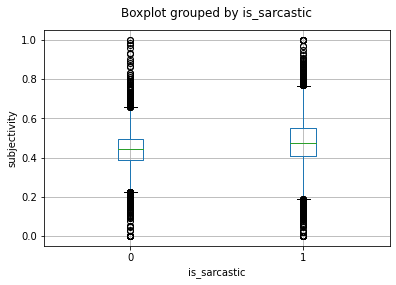

In [ ]:
#@title
boxplot = df.boxplot('subjectivity', 'is_sarcastic')
boxplot.set_ylabel("subjectivity")
titel = boxplot.set_title("")

Der Boxplot der Subjektivität weist hingegen etwas deutlichere Unterschiede auf. Hier unterscheidet sich sowohl der Median, als auch die Distanz zwischen 25er- und 75-er-Perzentil als auch die Distanz zwischen Maximum und Minimun zwischen den Texten. 
Es gibt also generell eine höhere Subjektivität bei sarkastischen Texten als bei nicht sarkastischen, da hier der Median mehr in Richtung Subjektivität, also dem Wert 1.0, geht. 
Auch das Maximum bei sarkastischen Texten ist höher als bei nicht sarkastischen. Entgegen der Erwartung ist das Minimum allerdings sogar geringer als bei nicht sarkastischen Texten.

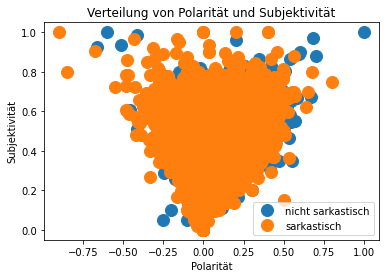

In [ ]:
#@title
import matplotlib.pyplot as plt

groups = df.groupby('is_sarcastic')
fig, ax = plt.subplots()
for name, group in groups:
    if name == 0:
      titel = "nicht sarkastisch"
    else:
      titel = "sarkastisch"
    ax.plot(group['polarity'], group['subjectivity'], marker='o', linestyle='', ms=12, label=titel)
ax.set_xlabel("Polarität")
ax.set_ylabel("Subjektivität")
ax.set_title("Verteilung von Polarität und Subjektivität")
ax.legend()
plt.show()

Auch bei der Korrelation zwischen Polarität und Subjektivität bei sarkastischen und nicht sarkastischen Texten lässt sich kein Unterschied feststellen. Die orangen und blauen Punkte sind annähernd deckungsgleich.

Obwohl der Boxplot nur bei der Subjektivität etwas größere Unterschiede aufweist, nehmen wir beide Kriterien mit in das Neuronale Netz auf, falls es einen Zusammenhang gibt, der sich zwar alleine nicht erkennen lässt, aber mit anderen Features zu einer besseren Klassifizierung führt.

##Emotionenanalyse

In der Emotionenanalyse werden Emotionen mit Hilfe einer [Emotionsliste](https://github.com/attreyabhatt/Sentiment-Analysis/blob/master/emotions.txt) gefunden, die bestimmten Schlagwörtern eine Emotion zuschreibt. Wenn im eingegebenen Text diese Schlagwörter vorkommen, dann kann die dahinter stehende Emotion dem Text zugeordnet werden.  

Auch hier liegt die Annahme zu Grunde, dass sarkastische Texte stärker emotionalisiert sind als nicht sarkastische. Sollte sich dies bewahrheiten, kann die Analyse die Klassifizierung verbessern.

Die Gefahr bei diesem Verfahren ist, dass die Emotionsliste zu wenig Schlagwörter (und Varianten dieser Wörter abdeckt) und nicht genügend Emotionen erkannt und zugeordnet werden können. Dadurch kann die Analyse an Aussagekraft verlieren

In [ ]:
#@title
import pandas as pd
import string
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Read data and split context, headlines and labels
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test_data.csv', sep=",")
# Extract emotions and tags from file
emotion_tags = []
emotion_set = set()
with open('/content/drive/My Drive/Colab Notebooks/emotions.txt') as file: 
  for line in file:
    clear_line = line.replace("\n", "").replace("'", "").replace(",", "").strip()
    word, emotion = clear_line.split(": ")
    emotion_tags.append([word, emotion])
    emotion_set.add(emotion)

In [ ]:
#@title
# Counts the different emotions from the given list
def count_occurences(emotion_list): 
  emotion_occ_list = []
  for emotion in emotion_list:
    #look for emotion in the occ_list and append if not in there
    i = 0
    found = False
    while (i < len(emotion_occ_list) and not found):
      if emotion == emotion_occ_list[i][0]:
        emotion_tuple = list(emotion_occ_list[i])
        emotion_tuple[1] += 1
        emotion_occ_list[i] = tuple(emotion_tuple)
        found = True
      i += 1
    if not found:
      emotion_occ_list.append((emotion, 1))
  return emotion_occ_list

In [ ]:
#@title
emotion_counter = []
stopwords_list = stopwords.words('english')
#insert new column for emotions
df['emotions'] =[[('emotion', 0)] for _ in range(len(df))]
#iterate rows and get emotions
for index, row in df.iterrows():
    headline = row['headline']
    context = row['context']
    #convert to lowercase
    context = context.lower()
    headline = headline.lower()
    #delete punctuation and tokenize
    cleaned_headline = headline.translate(str.maketrans("", "", string.punctuation))
    tokenized_headline = cleaned_headline.split()
    cleaned_context = context.translate(str.maketrans("", "", string.punctuation))
    tokenized_context = cleaned_context.split()
    #delete stopwords
    tokens = []
    for token in tokenized_headline:
      if token not in stopwords_list:
        tokens.append(token) 
    for token in tokenized_context:
      if token not in stopwords_list:
        tokens.append(token)      
    #search for emotions in tokens
    text_emotions = []
    for token in tokens:
      for emotion in emotion_tags:
        if emotion[0] == token:
          text_emotions.append(emotion[1])
    emotions_occ = count_occurences(text_emotions)
    df.at[index,'emotions'] = emotions_occ
    emotion_counter.append(emotions_occ) #occ list of emotions in one text

In [ ]:
#@title
import json
#save dataframe
f_csv = open('/content/data_1.csv', 'w')
f_json = open('/content/data_1.json', 'w')
with f_csv and f_json:
    df.to_csv(f_csv, index=False)
    json_data = df.to_json(orient="index")
    json.dump(json_data, f_json)

In [ ]:
#@title
# Split emotions into sarcastic and not sarcastic
sarcasm = df["is_sarcastic"].tolist()
key_data = {}
key_data_sarc = {}
for i in range (len(emotion_counter)):
  if len(emotion_counter[i]) > 0:
    if sarcasm[i] == 0 : #sarcastic 
      for j in range(len(emotion_counter[i])):
        if emotion_counter[i][j][0] in key_data:
          key_data[emotion_counter[i][j][0]] += emotion_counter[i][j][1] 
        else:
          #new
          key_data[emotion_counter[i][j][0]] = emotion_counter[i][j][1]
    else: #not sarcastic
      for j in range(len(emotion_counter[i])):
        if emotion_counter[i][j][0] in key_data_sarc:
          key_data_sarc[emotion_counter[i][j][0]] += emotion_counter[i][j][1] 
        else:
          #new
          key_data_sarc[emotion_counter[i][j][0]] = emotion_counter[i][j][1]

In [ ]:
#@title
def printEmotionOcc(data):
  sorteditems = sorted(data.items())
  keys = []
  vals = []
  for key,val in sorteditems:
    keys.append(key)
    vals.append(val)

  plt.bar(keys, vals)
  plt.xticks(rotation=90)
  plt.show()

**Emotionen in nicht sarkastischen Artikeln:**



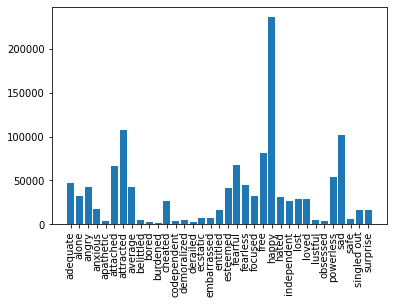

In [ ]:
#@title
printEmotionOcc(key_data)

**Emotionen in sarkastischen Artikeln:**

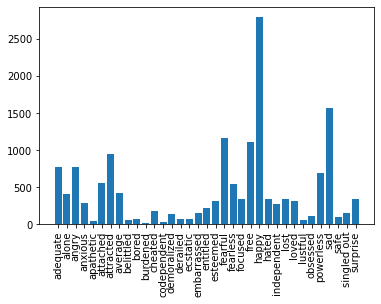

In [ ]:
#@title
printEmotionOcc(key_data_sarc)


**Wie werden Ergebnisse der Emotionsanalyse verwendet?**

Anhand der Grafiken lässt sich erkennen, dass die Emotionen sowohl in sarkastischen als auch nicht sarkastischen Texten ähnlich verteilt sind. Allerdings unterscheidet sich die Anzahl der Emotionen stark. Das liegt vor allem daran, dass sarkastische Artikel eher kürzer sind als nicht sarkastische. Die Länge des Textes soll aber nicht zur Klassifikation von Sarkasmus verwendet werden, da der Fokus dieses Projektes darauf liegt, Sarkasmus anhand einer Überschrift zu erkennen. Die Annahme, dass sarkastische Texte mehr Emotionen erhalten, kann der gegebene Datensatz nicht bestätigen.

Sowohl in nicht sarkastischen als auch sarkastischen Artikeln und Überschriften finden sich zudem allgemein sehr wenig Emotionsschlagworte. Daher werden die Emotionen aus Überschrift und Artikel zusammen betrachtet. 

Aufgrund der wenigen Vorkommnisse von Emotionen, haben wir uns dazu entschieden, auch die Anzahl der Emotionen nicht zu berüchsichtigen, sondern als Feature nur aufzunehmen, welche Emotionen einem Artikel zugeordnet sind.


##Slanganalyse

In sarkastischen Texten wird möglicherweise häufiger Umgangssprache/Slang verwendet, als in nicht sarkastischen Texten. Allerdings liegt auch die Vermutung nahe, dass in den Artikelüberschriften aufgrund der Kürze wenig bis gar kein Slang zu finden ist.

Da es keine frei verfügbare Slang-Library gibt, die herausfinden kann, ob ein Text in Slang geschrieben wurde oder nicht, muss dies anhand bestimmter, selbst gewählter Eigenschaften herausgefunden werden.

Im Folgenden wird untersucht, ob ein Text profan ist oder nicht. Dafür wurde die Library [*profanity-check*](https://pypi.org/project/profanity-check/) verwendet, damit dennoch herausgefunden werden kann, ob ein Text anstößige Worte enthält oder nicht. 

Um eine verbesserte Slanganalyse zu gewährleisten, könnten nun noch mehr Schlagworte ermittelt werden, in der Art, wie die Emotionen bereits ermittelt wurden. Es gibt also eine Liste mit Triggerworten, die angeben, ob es sich um ein Slang-Wort handelt oder nicht. Das Problem bei der Slangerkennung selbst ist, dass z.B. der Dialekt oder die Altersgruppe eine Rolle spielen kann und wir uns deswegen von Schlagworten keine umfassend gute Klassifizierung versprechen. 
Es könnte zum Beispiel sein, dass es ein gutes Dictionary für den einen Dialekt gibt, für einen anderen Dialekt ist das Wörterbuch aber nicht so umfassend. Damit würde Sarkasmus in einem Dialekt besser klassifiziert werden als in einem anderen. Zudem gibt es immer wieder Wortneuschöpfungen und eine Veränderte Bedeutung eines bestehenden Wortes, welches das Ergebnis und somit die Klassifikation verfälschen kann.

Die verwendete Library *profanity-check* nutzt kein ein Dictionary zum Finden bestimmter Wörter, sondern eine SVM und verspricht damit eine umfassendere und performantere Analyse profaner Wörter. Als Output liefert sie einen Wert zwischen 0.0 und 1.0 zurück, welcher beschreibt, wie beleidigend ein Text ist. 0.0 ist dabei nicht profan und 1.0 ist sehr profan.

In [ ]:
#@title
!pip install profanity-check
from profanity_check import predict, predict_prob
import pandas as pd
import csv

In [ ]:
#@title
def isOffensive(text):
  probs = predict_prob([text])
  return probs[0]

In [ ]:
#@title
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test_data_1.csv', sep=",")
offenses = []
for i, row in df.iterrows():
    h_offense = isOffensive(df['headline'][i])
    c_offense = isOffensive(df['context'][i])
    offenses.append(dict(is_sarcastic=df['is_sarcastic'][i], headline_offense=h_offense, context_offense=c_offense))
    df.loc[i,'headline_offense'] = h_offense
    df.loc[i,'context_offense'] = c_offense

#save dataframe
f_csv = open('/content/data_1.csv', 'w')
with f_csv:
    df.to_csv(f_csv, index=False)

f_csv = open('/content/drive/My Drive/offenses.csv', 'w')

with f_csv:
    #prepare csv summary analysis
    fnames = ['is_sarcastic', 'headline_offense', 'context_offense']
    csv_writer = csv.DictWriter(f_csv, fieldnames=fnames)    
    csv_writer.writeheader()

    entry = {}
    
    for element in offenses:
      entry['is_sarcastic'] = element['is_sarcastic']
      entry['headline_offense'] = element['headline_offense']
      entry['context_offense'] = element['context_offense']
      csv_writer.writerow(entry)

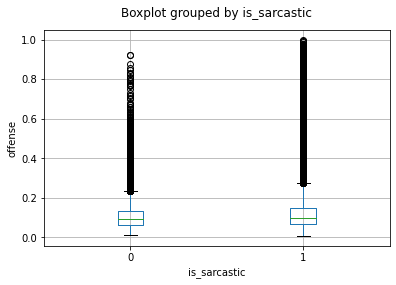

In [ ]:
#@title
boxplot = df.boxplot('headline_offense', 'is_sarcastic')
boxplot.set_ylabel("offense")
titel = boxplot.set_title("")

In den folgenden Diagrammen wird die Anstößigkeit in den Überschriften und den jeweiligen Inhalten der Artikel betrachtet.

Bei der Anstößigkeit in den Überschriften ist erkennbar, dass sarkastische Texte eher profan sind als nicht sarkastische, obgleich beide Texte im Allgemeinen wenig profan sind.

Das Minimun liegt bei beiden Diagrammen nahe bei 0.0. Auffällig sind jedoch die Ausreißer, die zum einen bei beiden Diagrammen nur überhalb des Maximums vorkommen, bei sarkastischen Texten haben Überschriften aber auch Werte 1.0, während dies bei nicht sarkastischen Texten nicht vorkommt.

Daraus könnte man folgenden Schluss ziehen: ist ein Text sehr profan geschrieben, ist er mit höherer Wahrscheinlichkeit sarkastisch. Ist er das nicht, liefert das aber keine zuverlässige Aussage.

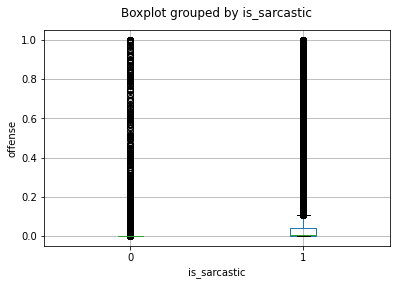

In [ ]:
#@title
boxplot = df.boxplot('context_offense', 'is_sarcastic')
boxplot.set_ylabel("offense")
titel = boxplot.set_title("")

Die Anstößigkeit in den Artikelinhalten fällt bei nicht sarkastischen Artikeln extrem niedrig aus. Der Median, das 25-er und 75-Perzentil sowie Minimum und Maximun liegen so nahe bei 0.0 und so nahe beieinander, dass man sie nicht sehen kann. Ausreißer finden sich ebenfalls nahe bei 0, allerdings ist das Maximum der Ausreißer auch bei 1.0 angesiedelt. Man kann aber im Vergleich zu den Ausreißern bei sarkastischen Texten anhand der Färbung sehen, dass es bei nicht sarkastischen Texten weniger Ausreißer gibt. 
Obwohl der Median bei nicht sarkastischen Texten immer noch nahe 0.0 liegt, unterscheidet sich das Maximum hier vergleichsweise stark von dem Maximum der nicht sarkastischen Texte. 

Dies scheint also ein guter Indikator für sarkastische Texte zu sein. Andersrum gilt dies aber nicht zwangsläufig.
D.h. beinhaltet ein Text anstößige Inhalte, ist die Wahrscheinlichkeit höher, dass es ein sarkastischer Text ist, beinhaltet er aber keine profanen Begriffe, ist das kein Indikator für einen nicht sarkastischen Text, da die generelle Anstößigkeit trotz allem sehr niedrig ausfällt. 

# Methoden zur Klassifizierung von Sarkasmus

Um Sarkasmus zu klassifizieren gibt es im Gebiet der KI verschiedene Verfahren. In diesem Projekt beschränken wir  uns auf ein Neuronales Netz un d zum Vergleich eine Support Vector Machine. Als Deep Learning Framework wurde Keras ausgesucht.

##Neuronales Netz mit Keras

Das folgende Vorgehe ist angelehnt an [Practical Text Classification With Python and Keras](https://realpython.com/python-keras-text-classification/).

**Preprocessing**

Worte, wie sie in den Überschriften vorkommen, können nicht direkt in das neuronale Netz gegeben werden, da den einzelnen Buchstaben in einem Wort keine Bedeutung entnommen werden und zu einer Zahl umgewandelt werden kann, damit das neuronale Netz sie verarbeiten kann. 

Mit *scikit-learn* können mit dem [Count Vectorizer](https://scikit-learn.org/stable/modules/feature_extraction.html) Texte transformiert und so in ein neuronales Netz gegeben werden. Zunächst wird den einzelnen Worten ein numerischer Token zugeordnet, anschließend werden die Tokens im Text gezählt und anhand der Anzahl der Vorkomnisse gewichtet. Dieses Verfahren nennt man auch Bag-of-Words und ist ein gängiges in der Analyse von Texten.

**Das Model**

Beim Bau unseres Models haben wir uns an das allgemeine Vorgehen gehalten, für die Hidden Layers eine ReLu-Funktion (rectified linear unit) als Aktivierungsfunktion zu nutzen und eine Sigmoidfunktion für den Output Layer, da es sich bei unserem Problem um eine binäre Klassifikation (sarkastisch oer nicht sarkastisch) handelt.
Außerdem haben wir die Batchgröße auf 10 festgelegt, da dies eine allgemeiner Standard für die Anfangsgröße ist und auch bei Veränderungen keine Verbesserung erzielt wurde. 

In [ ]:
#@title
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from keras.models import Sequential
from keras import layers

In [ ]:
#@title
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#Plot the history of the training
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [ ]:
#@title
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data_all_features.csv', sep=",")

headlines = df['headline'].values
y = df['is_sarcastic'].values
sentences_train, sentences_test, y_train, y_test = train_test_split(headlines, y, test_size=0.25, random_state=1000)

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

input_dim = X_train.shape[1]  # Number of features

**Erster Test**

Training Accuracy: 0.9993
Testing Accuracy:  0.8169


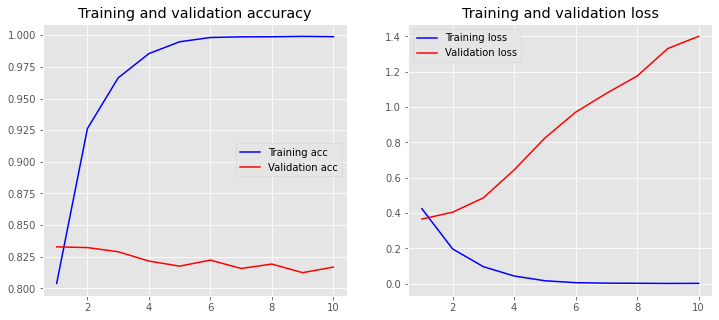

In [ ]:
#@title
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, verbose=False, validation_data=(X_test, y_test), batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

**Hidden Layer und Epochen**

Auf der Suche nach dem besten Model wird im Folgenden zum Vergleich die Anzahl der Hidden Layer und die Anzahl der Epochen variiert.

In [ ]:
#@title
def buildModel(numNeurons,numHiddenLayer,  numEpochs):
  model = Sequential()
  i = 0; 
  for i in range(0, numHiddenLayer):
    model.add(layers.Dense(numNeurons, input_dim=input_dim, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  history = model.fit(X_train, y_train, epochs=numEpochs, verbose=False, validation_data=(X_test, y_test), batch_size=10)
  loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
  print("Training Accuracy: {:.4f}".format(accuracy))
  loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
  print("Testing Accuracy:  {:.4f}".format(accuracy))
  plot_history(history)

Number hidden layer: 3    Number epochs: 5
Training Accuracy: 0.9980
Testing Accuracy:  0.8196


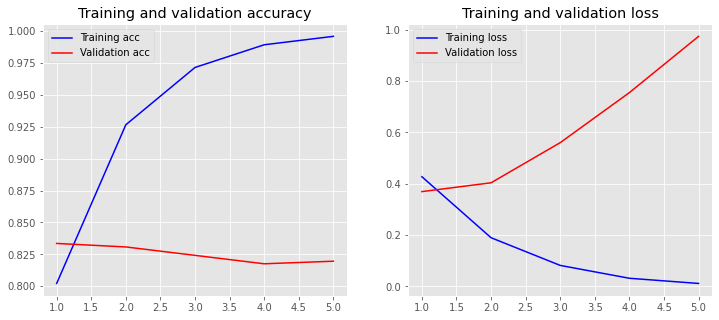

Number hidden layer: 6    Number epochs: 5
Training Accuracy: 0.9976
Testing Accuracy:  0.8218


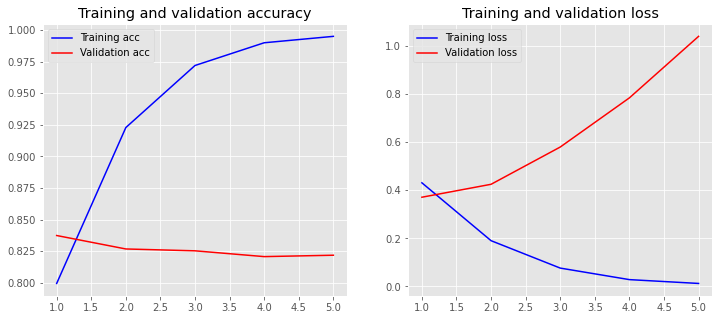

Number hidden layer: 9    Number epochs: 5
Training Accuracy: 0.9971
Testing Accuracy:  0.8213


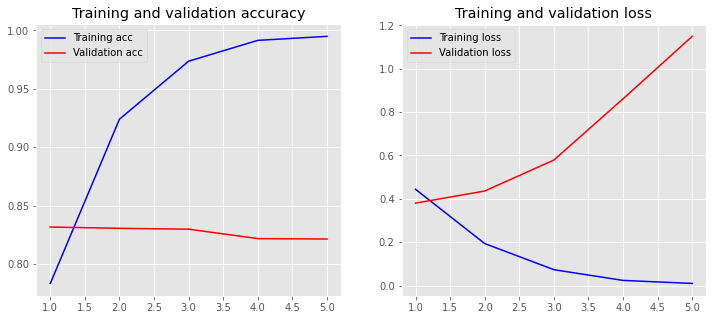

Number hidden layer: 12    Number epochs: 5
Training Accuracy: 0.9982
Testing Accuracy:  0.8127


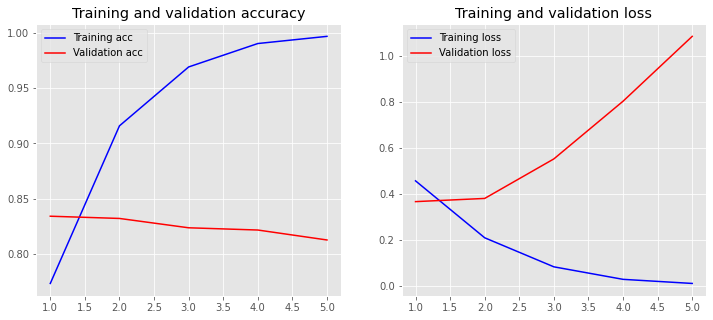

Number hidden layer: 3    Number epochs: 10
Training Accuracy: 0.9991
Testing Accuracy:  0.8161


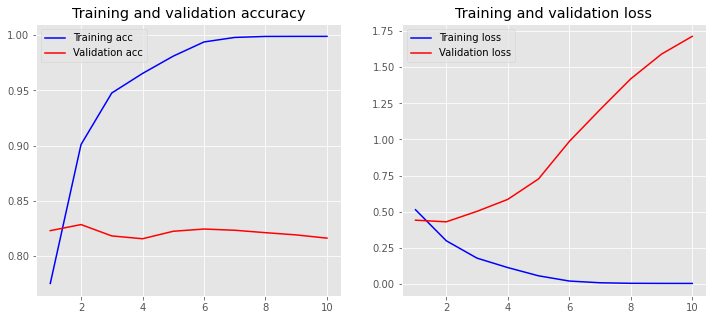

Number hidden layer: 6    Number epochs: 10
Training Accuracy: 0.9913
Testing Accuracy:  0.8240


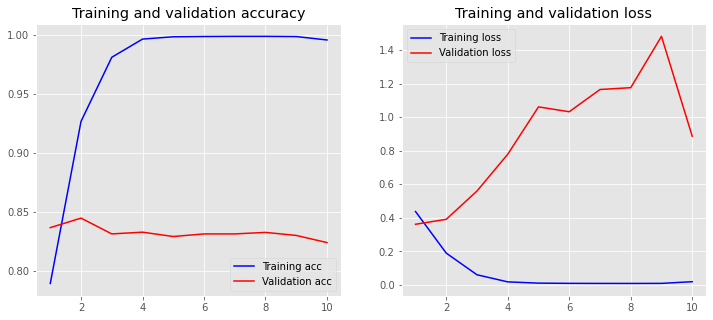

Number hidden layer: 9    Number epochs: 10
Training Accuracy: 0.9982
Testing Accuracy:  0.8138


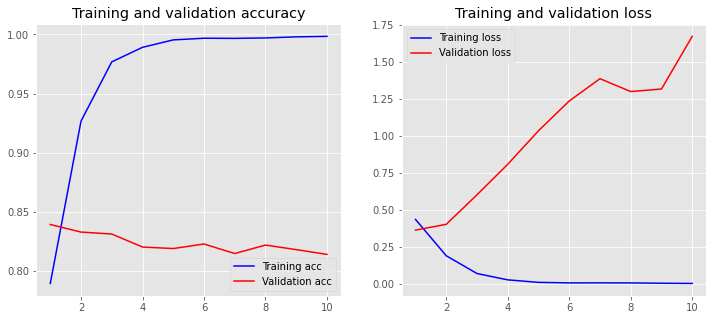

Number hidden layer: 12    Number epochs: 10
Training Accuracy: 0.9954
Testing Accuracy:  0.8217


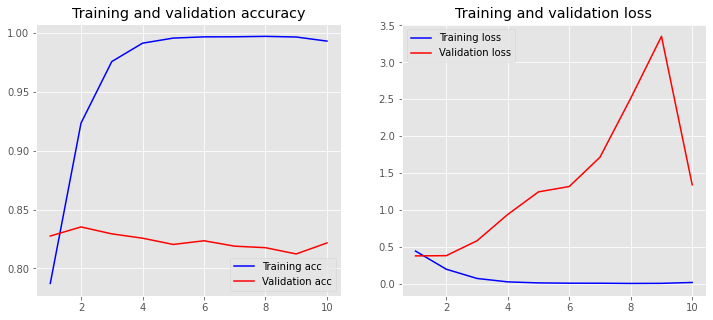

Number hidden layer: 3    Number epochs: 15
Training Accuracy: 0.9991
Testing Accuracy:  0.8108


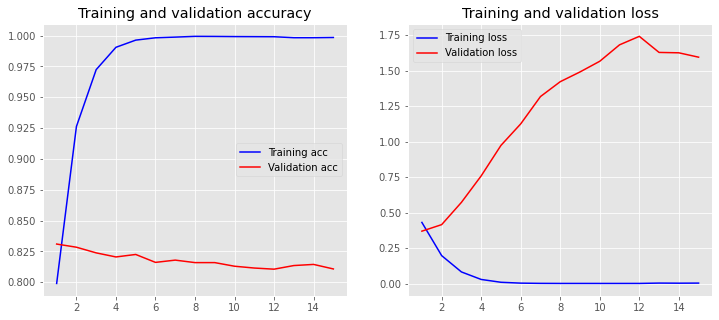

Number hidden layer: 6    Number epochs: 15
Training Accuracy: 0.9999
Testing Accuracy:  0.8196


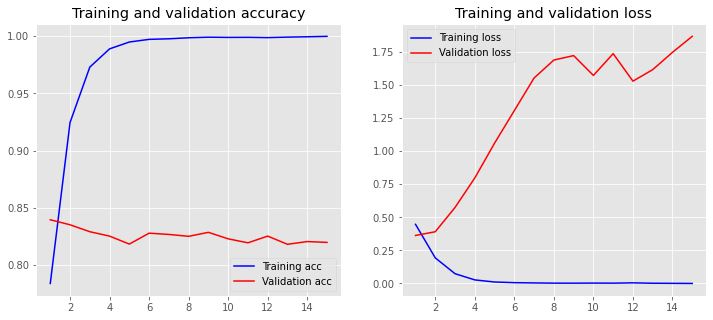

Number hidden layer: 9    Number epochs: 15
Training Accuracy: 0.9966
Testing Accuracy:  0.8174


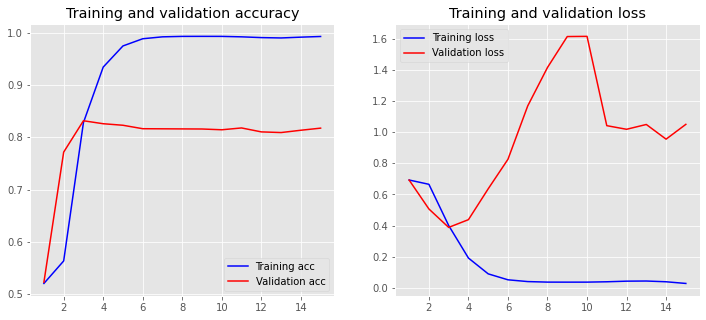

Number hidden layer: 12    Number epochs: 15
Training Accuracy: 0.9976
Testing Accuracy:  0.8136


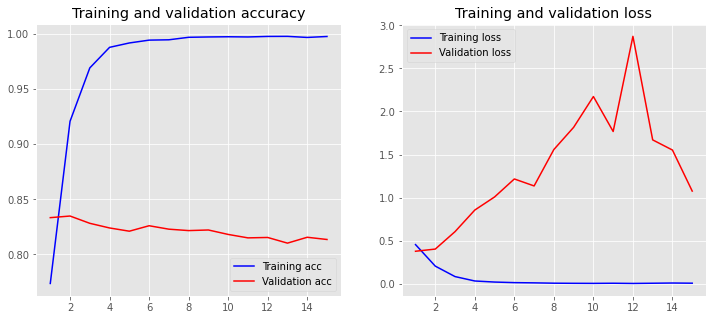

Number hidden layer: 3    Number epochs: 20
Training Accuracy: 1.0000
Testing Accuracy:  0.8101


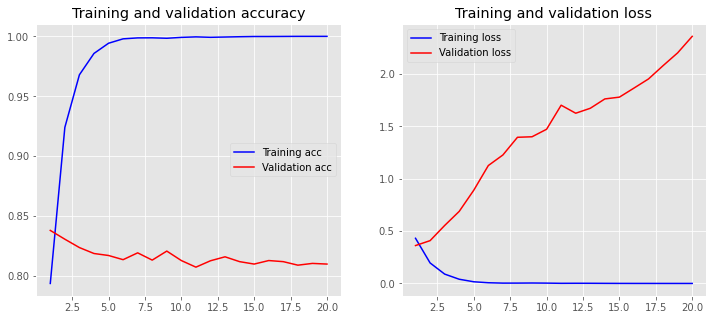

Number hidden layer: 6    Number epochs: 20
Training Accuracy: 1.0000
Testing Accuracy:  0.8066


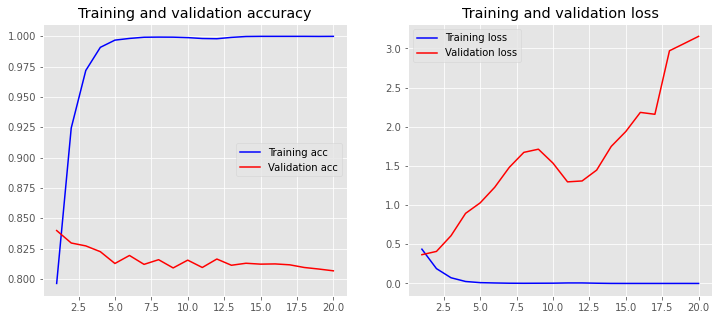

Number hidden layer: 9    Number epochs: 20
Training Accuracy: 0.9994
Testing Accuracy:  0.8141


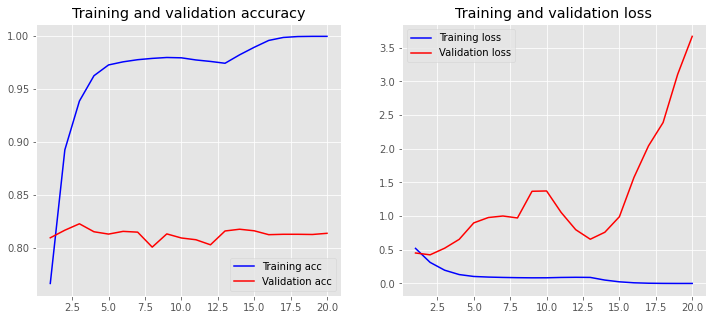

Number hidden layer: 12    Number epochs: 20
Training Accuracy: 0.5210
Testing Accuracy:  0.5226


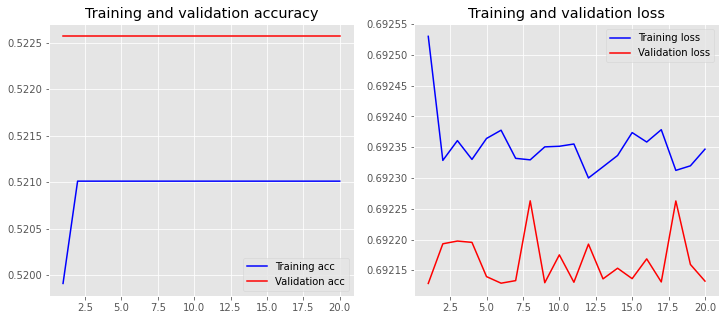

In [ ]:
#@title
numNeurons = 10
numHiddenLayer = 1;
numEpochs = 1;

for numEpochs in range(1,5):
  for numHiddenLayer in range(1,5):
    print("Number hidden layer: " + str(numHiddenLayer * 3) + "    Number epochs: " + str(5 * numEpochs) )
    buildModel(numNeurons, numHiddenLayer * 3, numEpochs * 5) 

Beim Vergleich der verschiedenen Modelle fällt auf, dass zu viele Hidden Layers eine Verschlechterung darstellen und zu viele Epochen zu Overfitting führen.

Außerdem ist auffällig, dass mit 12 hidden Layers und 20 Epochen der Genauigkeitswert von über 81% auf etwas knapp über 52% einbricht, und das sowohl bei den Trainings- als auch Testdaten.
Dieses Verhalten haben wir nicht erwartet und können uns auch nicht erklären, insbesondere bei den Trainingsdaten gibt. 

Folgende Parametrisierungen wollen wir zum Vergleich heranziehen. 
Damit kann damit die Anzahl der Epochen sowie die Anzahl der Hidden Layer und deren Einfluss auf die Genauigkeit bei Test und Training festgestellt werden. 

* Number hidden layer: 12    Number epochs: 20
Training Accuracy: 0.5210
Testing Accuracy:  0.5226

* Number hidden layer: 9    Number epochs: 20
Training Accuracy: 0.9994
Testing Accuracy:  0.8141

* Number hidden layer: 12    Number epochs: 15
Training Accuracy: 0.9976
Testing Accuracy:  0.8136

Diese Werte sehen sehr ähnlich aus, und vor allem zu allen anderen Werten, die produziert wurden. Es gibt keine wesentliche Tendenz zu einem schlechtenren Wert. 
Mit mehr Epochen würden wir zudem eher ein Overfitting erwarten, also eine Annäherung der Trainings-Genauigkeit gegen 100%, statt den beobachteten Einbruch.

Das beste getestete Model hat 10 Epochen und 6 Hidden Layer. Dieses Model wird für die weiteren Einstellungen verwendet.

**Neuronenanzahl**

Number neurons: 5
Training Accuracy: 0.9990
Testing Accuracy:  0.8127


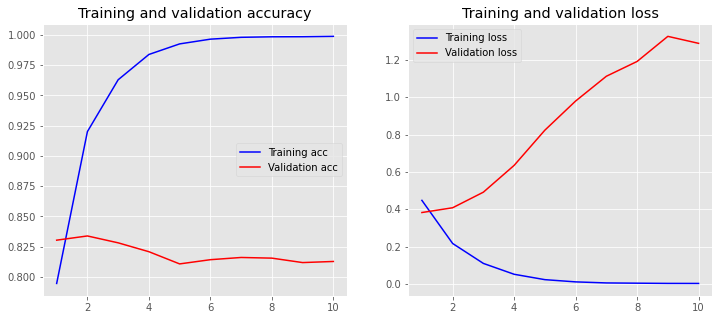

Number neurons: 8
Training Accuracy: 1.0000
Testing Accuracy:  0.8246


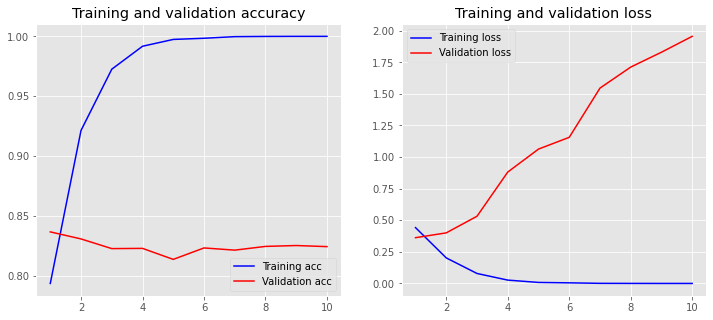

Number neurons: 11
Training Accuracy: 0.9988
Testing Accuracy:  0.8207


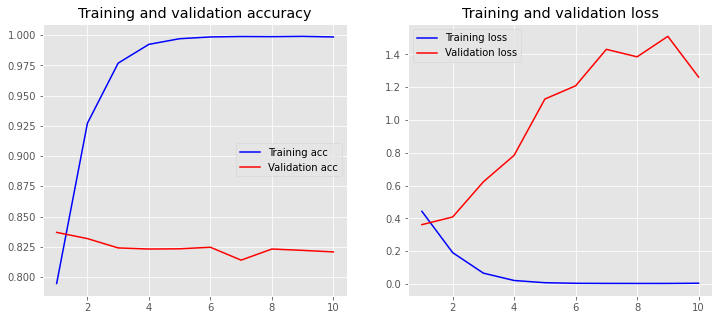

Number neurons: 14
Training Accuracy: 1.0000
Testing Accuracy:  0.8114


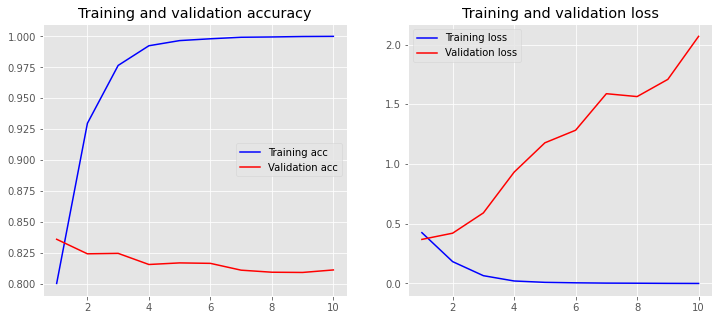

Number neurons: 17
Training Accuracy: 0.9867
Testing Accuracy:  0.7936


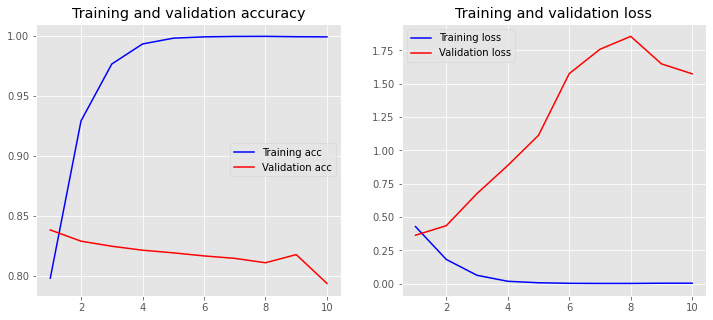

Number neurons: 20
Training Accuracy: 1.0000
Testing Accuracy:  0.8233


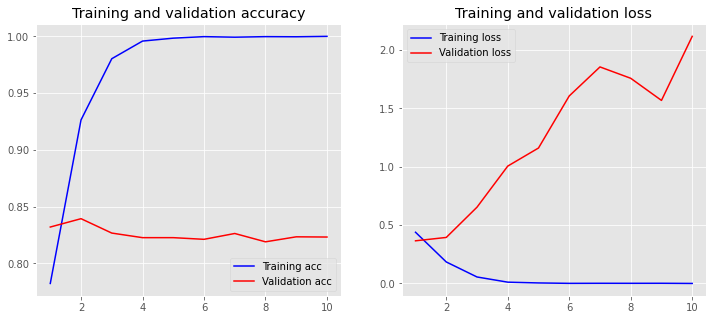

In [ ]:
#@title
numNeurons = 1
numHiddenLayer = 6;
numEpochs = 10;

for numNeurons in range(0,6):
    print("Number neurons: " + str(5 + (numNeurons * 3)))
    buildModel(5 + (numNeurons * 3), numHiddenLayer, numEpochs) 

Die Veränderung bei der Anzahl der Neuronen in einem Layer zeigt, dass die Einstellung von 10 Neuronen im optimalen Bereich liegt. Sowohl weniger, als auch mehr Neuronen lief kein wesentlich besseres Ergebnis.

**Optimierungsfunktion**

Keras bietet verschiedene Optimierungsfunktionen. Diese Funktionen beeinflussen das Lernverhalten des Neuronalen Netzes, genauer Gradientenverfahren. Folgende Funktionen wurden zum Test ausgewählt:

*   Adam
*   Nadam
*   Adamax

*Adam* ist eines der meistgenutzten Verfahren. *Nadam* und *Adamax* erweitern dieses auf unterschiedliche Weisen.

Im Folgenden werden die Optimierungsfunktionen am ersten Testfall getestet. 

In [ ]:
#@title
def modelWithoptimizer(opt):
  model = Sequential()
  model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
  model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  history = model.fit(X_train, y_train, epochs=10, verbose=False, validation_data=(X_test, y_test), batch_size=10)
  loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
  print("Training Accuracy: {:.4f}".format(accuracy))
  loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
  print("Testing Accuracy:  {:.4f}".format(accuracy))
  plot_history(history)

Adam:
Training Accuracy: 0.9996
Testing Accuracy:  0.8147


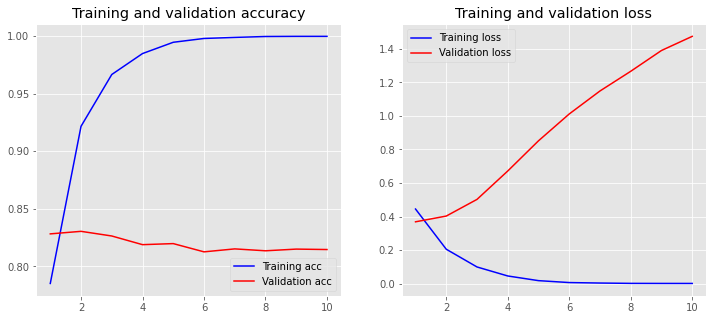

Nadam:
Training Accuracy: 1.0000
Testing Accuracy:  0.8226


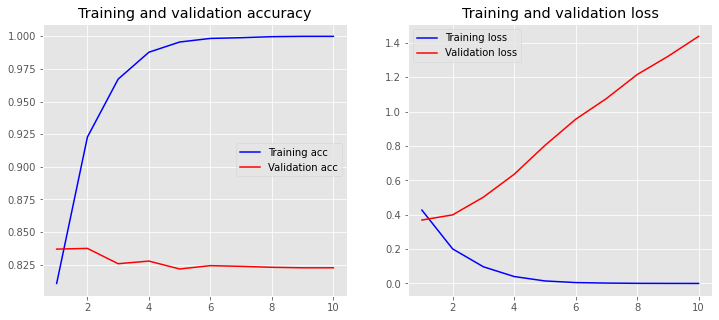

Adamax:
Training Accuracy: 0.9723
Testing Accuracy:  0.8360


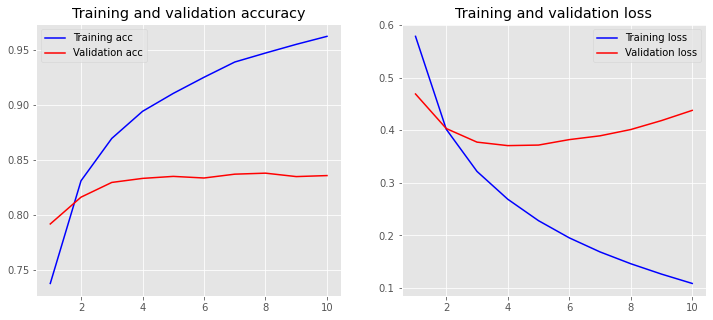

In [ ]:
#@title
print("Adam:")
modelWithoptimizer('adam')
print("Nadam:")
modelWithoptimizer('nadam')
print("Adamax:")
modelWithoptimizer('adamax')

Obwohl das Neuronale Netz nur ein Feature, nämlich die vektorisierten Worte, bekommt, liefert das Neuronale Netz mit zwischen 80% und 83% Genauigkeit bei den Testdaten ein gutes Ergebnis. 
Dabei wurden an mehreren Parametern Anpassungen gemacht. 

* Anzahl der Epochen: anhand der erstellen Diagramme der Trainingshistorie lässt sich erkennen, dass eine geringe Anzahl an Epochen zu einer besseren Genauigkeit bei der Klassifizierung der Testdaten führt. Je höher die epochenanzahl, desto mehr schlägt der Graph der Loss-Funktion über die Testdaten aus.

* Anzahl der Hidden Layer: Sind zu viele Hidden Layer im Neuronalen Netz, verringert sich die Genauigkeit bei der Klassifizierung der Testdaten wieder ein wenig. 

* Optimizer: Es wurden verschiedene Optimierungsfunktionen getestet. Dabei stellte sich heraus, dass Adamax die höchste Genauigkeit zru Klassifizierung der Testdaten liefert

##Neuronales Netz mit mehreren Features

Das folgende Vorgehe ist angelehnt an [Building a mixed-data neural network in Keras to predict accident locations](https://heartbeat.fritz.ai/building-a-mixed-data-neural-network-in-keras-to-predict-accident-locations-d51a63b738cf).

Im Folgenden wird ein neuronales Netz mit folgenden Features trainiert:


*   Überschrift
*   Beleidigungen/Anstößigkeit
*   Emotionen
*   Sentiments (Polarität und Subjektivität)





Da die Features verschiedene Formate haben werden sie aufgeteilt und als seperate Inputs für drei Sub-Modelle verarbeitet. Das ist zunächst das Model für die Überschriften, welche in Textform vorliegen, das Model für die Emotionen, welche ebenfalls in Textform vorliegen und das Model für die numerischen Werte der Sentiments und der Anstößigkeit.
Die drei beschriebenen Sub-Modelle werden zu einem Model verbunden, indem ihre Outputs in weiteren Neuronen verarbeitet werden und zu der finalen Outputschicht und der Klassifizierung führen. Das gesamte Model wird als eins trainiert, so das ihre Werte gemeinsam angepasst und eingestellt werden. 

In [ ]:
#@title
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers.core import Dense
from keras.models import Sequential
from keras.optimizers import Adam # Other optimisers are available
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
import string
from keras.layers import Flatten, Input, concatenate
from keras.models import Model

In [ ]:
#@title
#Plots the training history
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [ ]:
#@title
#Create the input

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data_all_features.csv', sep=",")

#Format change for neural network with multiple features
#emotions as string and numeric features merges to one vector
df['num_features'] =[[0.0,0.0,0.0,0.0] for _ in range(len(df))]
df['emotion_feature'] =["" for _ in range(len(df))]
for index, row in df.iterrows():
  feature = [row['polarity'], row['subjectivity'], row['headline_offense'], row['context_offense']]
  df.at[index,'num_features'] = feature
  e_str = row['emotions'].replace('(', '').replace(')','').replace(',', '').replace('[','').replace(']','').replace('\'','').replace('1', '').replace('2','').replace('3', '').replace('4', '').replace('5', '').replace('6', '').replace('7','').replace('8','').replace('9','').replace('0','')
  df.at[index, 'emotion_feature'] = e_str

#Split training and test data
headlines = df['headline'].values
num_features = df['num_features'].tolist()
emotion_feature = df['emotion_feature'].values
y = df['is_sarcastic'].values
headlines_train, headlines_test, num_train, num_test, emotion_train, emotion_test, y_train, y_test = train_test_split(headlines, num_features, emotion_feature, y, test_size=0.25, random_state=1000)

In [ ]:
#@title
#Vectorize and normalize data for the NN
vectorizer_headlines = CountVectorizer()
vectorizer_headlines.fit(headlines_train)

X_h_train = vectorizer_headlines.transform(headlines_train)
X_h_test  = vectorizer_headlines.transform(headlines_test)

vectorizer_emotions = CountVectorizer()
vectorizer_emotions.fit(emotion_train)

X_e_train = vectorizer_emotions.transform(emotion_train)
X_e_test  = vectorizer_emotions.transform(emotion_test)

cs = MinMaxScaler()
X_n_train = cs.fit_transform(num_train)
X_n_test = cs.transform(num_test)

Beim Training des Models für das Neuronale Netz mit mehreren Features werden die Erfahrungen aus dem einfachen Model zuvor mit einbezogen. Dort wurde herausgefunden, dass der Optimizer **Adamax** das beste Ergebnis erzielt, daher wurde für das Training dieses Models nur dieser Optimizer verwendet.
Angepasst wurden nur die Anzahl der Hidden Layers und die Anzahl der Epochen mit Anlehnung an die besten Ergebnisse aus dem einfachen Model.

In [ ]:
#@title
#Creates model for input dimension
def create_model(dim, neuronsize, hiddenlayersize):
    model = Sequential()
    for i in range(0,hiddenlayersize):
      model.add(Dense(neuronsize, input_dim=dim, activation="relu"))
    model.add(Dense(4, activation="relu"))
    return model

**Das Model mit dem Optimizer "Adamax"**

In [ ]:
#@title
def trainAModel(hHL, nHL, eHL, epochs):
  # Create the models
  model_h = create_model(X_h_train.shape[1],10,hHL) #Headlines
  model_n = create_model(X_n_train.shape[1],8,nHL) #Numeric
  model_e = create_model(X_e_train.shape[1],8,eHL) #Emotions
  
  # Create the input to the final set of layers as the output of the models before
  combinedInput = concatenate([model_h.output, model_n.output, model_e.output])

  # The final fully-connected layers (one hidden, one output)
  x = Dense(4, activation="relu")(combinedInput)
  x = Dense(1, activation="sigmoid")(x)

  # Define the input/output for the final model
  model_final = Model(inputs=[model_h.input, model_n.input, model_e.input], outputs=x)

  # Compile the model 
  model_final.compile(loss="binary_crossentropy", metrics=['acc'], optimizer='adamax')

  # Train the model
  history = model_final.fit(
    [X_h_train, X_n_train, X_e_train], 
    y_train, 
    validation_data=([X_h_test, X_n_test, X_e_test], y_test), 
    epochs=epochs, 
    batch_size=10)

  # Evaluate the model
  loss, accuracy = model_final.evaluate([X_h_train, X_n_train, X_e_train], y_train, verbose=False)
  print("Training Accuracy: {:.4f}".format(accuracy))
  loss, accuracy = model_final.evaluate([X_h_test, X_n_test, X_e_test], y_test, verbose=False)
  print("Testing Accuracy:  {:.4f}".format(accuracy))
  plot_history(history)

***5 Epochen, 1 Hidden Layer***

Epoch 1/5
1635/1635 [==============================] - 4s 2ms/step - loss: 0.5593 - acc: 0.7106 - val_loss: 0.4532 - val_acc: 0.7783
Epoch 2/5
1635/1635 [==============================] - 3s 2ms/step - loss: 0.3760 - acc: 0.8341 - val_loss: 0.3551 - val_acc: 0.8385
Epoch 3/5
1635/1635 [==============================] - 4s 2ms/step - loss: 0.2892 - acc: 0.8827 - val_loss: 0.3204 - val_acc: 0.8580
Epoch 4/5
1635/1635 [==============================] - 4s 2ms/step - loss: 0.2349 - acc: 0.9081 - val_loss: 0.3050 - val_acc: 0.8686
Epoch 5/5
1635/1635 [==============================] - 4s 2ms/step - loss: 0.1948 - acc: 0.9259 - val_loss: 0.3012 - val_acc: 0.8743
Training Accuracy: 0.9414
Testing Accuracy:  0.8743


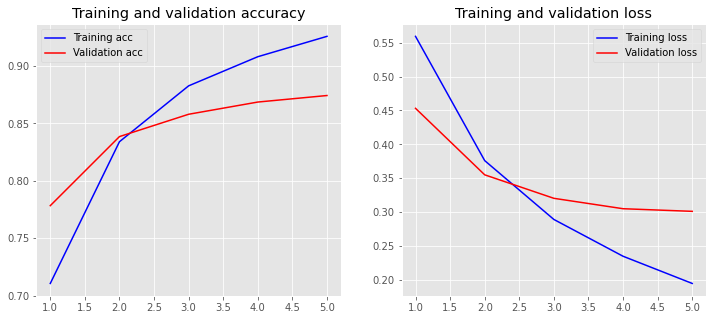

In [ ]:
#@title
trainAModel(1, 1, 1, 5)

***10 Epochen, 1 Hidden Layer***

Epoch 1/10
1635/1635 [==============================] - 4s 2ms/step - loss: 0.6042 - acc: 0.6640 - val_loss: 0.5061 - val_acc: 0.7938
Epoch 2/10
1635/1635 [==============================] - 4s 2ms/step - loss: 0.4372 - acc: 0.8511 - val_loss: 0.4140 - val_acc: 0.8484
Epoch 3/10
1635/1635 [==============================] - 4s 2ms/step - loss: 0.3462 - acc: 0.8936 - val_loss: 0.3636 - val_acc: 0.8637
Epoch 4/10
1635/1635 [==============================] - 3s 2ms/step - loss: 0.2799 - acc: 0.9161 - val_loss: 0.3356 - val_acc: 0.8664
Epoch 5/10
1635/1635 [==============================] - 4s 2ms/step - loss: 0.2296 - acc: 0.9319 - val_loss: 0.3233 - val_acc: 0.8668
Epoch 6/10
1635/1635 [==============================] - 4s 2ms/step - loss: 0.1915 - acc: 0.9440 - val_loss: 0.3261 - val_acc: 0.8706
Epoch 7/10
1635/1635 [==============================] - 4s 2ms/step - loss: 0.1618 - acc: 0.9528 - val_loss: 0.3220 - val_acc: 0.8728
Epoch 8/10
1635/1635 [==============================] - 4s 2ms

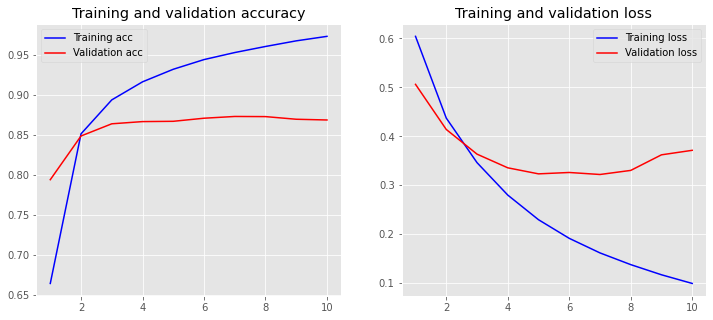

In [ ]:
#@title
trainAModel(1, 1, 1, 10)

***5 Epochen, 2 Hidden Layers***

Epoch 1/5
1635/1635 [==============================] - 4s 2ms/step - loss: 0.5413 - acc: 0.7716 - val_loss: 0.3894 - val_acc: 0.8273
Epoch 2/5
1635/1635 [==============================] - 4s 2ms/step - loss: 0.3119 - acc: 0.8732 - val_loss: 0.3258 - val_acc: 0.8538
Epoch 3/5
1635/1635 [==============================] - 4s 2ms/step - loss: 0.2396 - acc: 0.9060 - val_loss: 0.3072 - val_acc: 0.8683
Epoch 4/5
1635/1635 [==============================] - 4s 2ms/step - loss: 0.1911 - acc: 0.9282 - val_loss: 0.3058 - val_acc: 0.8712
Epoch 5/5
1635/1635 [==============================] - 4s 2ms/step - loss: 0.1547 - acc: 0.9432 - val_loss: 0.3114 - val_acc: 0.8745
Training Accuracy: 0.9563
Testing Accuracy:  0.8745


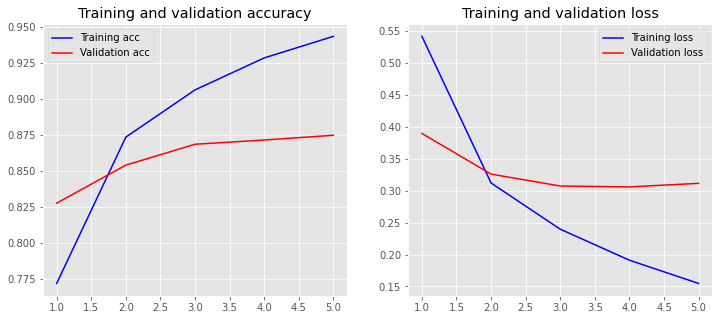

In [ ]:
#@title
trainAModel(2, 2, 2, 5)

***5 Epochen, 2 Hidden Layers and 4 Hidden Layers***

Epoch 1/5
1635/1635 [==============================] - 4s 3ms/step - loss: 0.5389 - acc: 0.7202 - val_loss: 0.4205 - val_acc: 0.8114
Epoch 2/5
1635/1635 [==============================] - 4s 3ms/step - loss: 0.3324 - acc: 0.8648 - val_loss: 0.3504 - val_acc: 0.8462
Epoch 3/5
1635/1635 [==============================] - 4s 3ms/step - loss: 0.2369 - acc: 0.9101 - val_loss: 0.3244 - val_acc: 0.8609
Epoch 4/5
1635/1635 [==============================] - 4s 3ms/step - loss: 0.1818 - acc: 0.9310 - val_loss: 0.3257 - val_acc: 0.8655
Epoch 5/5
1635/1635 [==============================] - 5s 3ms/step - loss: 0.1436 - acc: 0.9483 - val_loss: 0.3420 - val_acc: 0.8653
Training Accuracy: 0.9628
Testing Accuracy:  0.8653


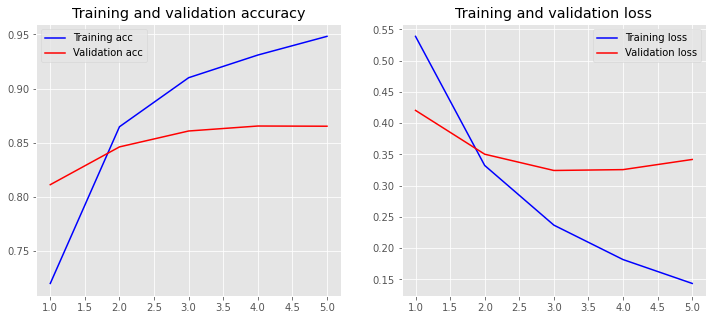

In [ ]:
#@title
trainAModel(2, 4, 4, 5)

Die verschiedenen Einstellungen von Hidden Layers uns Epochen zeigen, dass das Model relativ stabil ist. Allerdings ist eine Maximale Anzahl von 2 Hidden Layer in allen Sub-Modellen und unter 10 Epochen für das Training die besten Einstellungen. So erzielt das Model seine beste Genauigkeit in der Klasssifizierung.

## SVM

Support Vector Machines zur Klassifizierung des Datensets. Das folgende Vorgehe ist angelehnt an [A guide to Text Classification(NLP) using SVM and Naive Bayes with Python](https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34).

**Support Vector Maschines**

Neben einem Neuronalen Netz haben wir eine weitere Architektur genutzt, die Support Vector Machines. Diese beiden Ansätze sind sehr ähnlich. Trotzdem wollten wir herausfinden, ob die eine Architektur wesentlich besser ist als die andere. 

Folgende Parameter haben wir dafür angepasst:


*   Kernel (sigmoid, linear, rbf, poly)
*   Grad des Polynoms im Kernel
*   Regularization mit dem C-Wert 








In [ ]:
#@title
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
np.random.seed(500)

In [ ]:
#@title
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data_1.csv', sep=",")
# headlines to lower case + tokenization
for index, row in df.iterrows():
  df.at[index, 'headline'] = word_tokenize(row['headline'].lower())
# remove stop words and numeric values + word stemming/lemmenting
# tags to understand if the word is noun or verb or adjective
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(df['headline']):
    cleaned_words = []
    lemmatizer = WordNetLemmatizer()
    for word, tag in pos_tag(entry): # tag word
        if word not in stopwords.words('english') and word.isalpha():
            cleaned_word = lemmatizer.lemmatize(word,tag_map[tag[0]])
            cleaned_words.append(cleaned_word)
    df.loc[index,'cleaned_headline'] = str(cleaned_words)

In [ ]:
#@title
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['cleaned_headline'],df['is_sarcastic'],test_size=0.3)

Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(df['cleaned_headline'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

**SVM with linear kernel**

In [ ]:
#@title
SVM = svm.SVC(C=1.0, kernel='linear')
SVM.fit(Train_X_Tfidf,Train_Y)
# show accuracy of training set
predictions_SVM = SVM.predict(Train_X_Tfidf)
print("SVM Training Accuracy Score -> ",accuracy_score(predictions_SVM, Train_Y)*100)
# show accuracy of test set
predictions_SVM = SVM.predict(Test_X_Tfidf)
print("SVM Test Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Training Accuracy Score ->  87.33206632151517
SVM Test Accuracy Score ->  78.33333333333333


**SVM with sigmoid kernel**

In [ ]:
#@title
SVM = svm.SVC(C=1.0, kernel='sigmoid', gamma='scale')
SVM.fit(Train_X_Tfidf,Train_Y)
# show accuracy of training set
predictions_SVM = SVM.predict(Train_X_Tfidf)
print("SVM Training Accuracy Score -> ",accuracy_score(predictions_SVM, Train_Y)*100)
# show accuracy of test set
predictions_SVM = SVM.predict(Test_X_Tfidf)
print("SVM Test Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Training Accuracy Score ->  82.3513991742578
SVM Test Accuracy Score ->  77.58409785932722


**SVM with rbf kernel**

In [ ]:
#@title
SVM = svm.SVC(C=1.0, kernel='rbf', gamma='scale')
SVM.fit(Train_X_Tfidf,Train_Y)
# show accuracy of training set
predictions_SVM = SVM.predict(Train_X_Tfidf)
print("SVM Training Accuracy Score -> ",accuracy_score(predictions_SVM, Train_Y)*100)
# show accuracy of test set
predictions_SVM = SVM.predict(Test_X_Tfidf)
print("SVM Test Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Training Accuracy Score ->  97.45068484173275
SVM Test Accuracy Score ->  78.88379204892966


**SVM with polynomial kernel of second degree**

In [ ]:
#@title
SVM = svm.SVC(C=1.0, kernel='poly', degree=2, gamma='scale')
SVM.fit(Train_X_Tfidf,Train_Y)
# show accuracy of training set
predictions_SVM = SVM.predict(Train_X_Tfidf)
print("SVM Training Accuracy Score -> ",accuracy_score(predictions_SVM, Train_Y)*100)
# show accuracy of test set
predictions_SVM = SVM.predict(Test_X_Tfidf)
print("SVM Test Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Training Accuracy Score ->  98.97765253293139
SVM Test Accuracy Score ->  78.92966360856269


**SVM with polynomial kernel of second degree with C=1.5**

In [ ]:
#@title
SVM = svm.SVC(C=1.5, kernel='poly', degree=2, gamma='scale')
SVM.fit(Train_X_Tfidf,Train_Y)
# show accuracy of training set
predictions_SVM = SVM.predict(Train_X_Tfidf)
print("SVM Training Accuracy Score -> ",accuracy_score(predictions_SVM, Train_Y)*100)
# show accuracy of test set
predictions_SVM = SVM.predict(Test_X_Tfidf)
print("SVM Test Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)


SVM Training Accuracy Score ->  99.55436136050855
SVM Test Accuracy Score ->  78.79204892966361


**SVM with polynomial kernel of second degree with C=0.5**

In [ ]:
#@title
SVM = svm.SVC(C=0.5, kernel='poly', degree=2, gamma='scale')
SVM.fit(Train_X_Tfidf,Train_Y)
# show accuracy of training set
predictions_SVM = SVM.predict(Train_X_Tfidf)
print("SVM Training Accuracy Score -> ",accuracy_score(predictions_SVM, Train_Y)*100)
# show accuracy of test set
predictions_SVM = SVM.predict(Test_X_Tfidf)
print("SVM Test Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Training Accuracy Score ->  96.4873189593027
SVM Test Accuracy Score ->  77.64525993883792


Der Versuch, statt neuronalen Netzen eine Support Vector Machine zu nutzen, hat in ersten Versuchen, bei denen wir verschiedene Parametrisierung ausprobierten, kein besseres Ergebnis gebracht, auch nicht besser als das einfache neuronale Netz mit nur einem Feature. Daher wurde diese Variante nicht mehr genauer untersucht und das Augenmerk eher auf die Neuronalen Netze mit einem und mehreren Features genutzt.

# Fazit

Sarkasmus zu erkennen ist nicht leicht, weder für Maschine noch für Menschen. Viele Identifikatoren, die auf Sarkasmus hinweisen, sind nicht zwangsläufig spezielle Triggerworte, sondern vom Kontext abhängig. Der Kontext muss nicht zwangsläufig unmittelbar mit dem zu analysierenden Text aufgeklärt werden, sondern kann auch ein generelles Problem oder einen Missstand addressieren, der allegemein bekannt ist.   

Ein Problem ist, dass es nur wenige Ansätze für diesen Anwendunsgfall gibt, die nicht auf Basis von Dictionaries arbeiten. Die enthaltenen *Triggerworte*, also diejenigen Worte, die eine Aussage über ein bestimmtes Feature liefern, können den ständigen Wandel einer Sprache nicht vollständig abbilden. Wortneuschöpfungen können z.B. nicht berücksichtigt werden bzw. das Wörterbuch muss ständig aktualisiert werden. Dazu kommt, dass sich ein Model möglicherweise nicht generalisieren lassen kann, weil nicht alle Sprachen gleich funktionieren. Für unterschiedliche Sprachen muss es also unterschiedliche Modelle geben, für die eine große Menge an Daten benöigt werden. 

Forschern vom MIT ist es gelungen, auf Basis von Deep Learning ein Model zu entwickeln, welches Sarkasmus erkennt. Dieses arbeitet mit einer Genauigkeit von ca. 82% [(Artikel)](https://www.heise.de/newsticker/meldung/Deep-Learning-Algorithmus-erkennt-Sarkasmus-in-sozialen-Medien-3794584.html). Hierbei ging es darum, Posts in sozialen Netzwerken zu klassifizieren. Die Forscher nutzen dabei auch aus, dass viele User Emojis nutzen, um bestimmte Emotionen auszudrücken. Das war aufgrund des Datensatzes in diesem Projekt nicht möglich. Stattdessen konnte jedoch hier der Artikelinhalt genauer analysiert werden. 

Bei unserem Versuch haben wir zunächst nur die Überschrift analysiert und keine weiteren Features. Das ergab eine ungefähre Genauigkeit von ebenfalls 81-82%. Durch die Hinzunahme von den zuvor extrahierten Features konnte die Genauigkeit zur Klassifikation von Testdaten noch einmal auf über 86% verbessert werden. 
Das dieses Model sehr gut abschneidet, lässt sich dadurch erklären, dass der Kontext vermutlich sehr viel mehr Information liefert als ein einfacher Post, welcher mit Emojis versehen wurde. 